In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
# inputフォルダに格納されているファイルの一覧を出力
basePath = '/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input'
for dirname, _, filenames in os.walk(basePath):
    for filename in filenames:
        
        print(os.path.join(dirname, filename))

# データを読み込み
item_categories = pd.read_csv(basePath + '/item_categories.csv')
items = pd.read_csv(basePath + '/items.csv')
sales_train = pd.read_csv(basePath + '/sales_train.csv')
sample_submission = pd.read_csv(basePath + '/sample_submission.csv')
shops = pd.read_csv(basePath + '/shops.csv')
test = pd.read_csv(basePath + '/test.csv')


/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/item_categories.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/items.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sales_train.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/sample_submission.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/shops.csv
/content/drive/My Drive/CodeSeterpie/PredictFutureSales/input/test.csv


In [87]:
df = test.copy()

df['crossjoin_key'] = 1

data_fill = pd.DataFrame({'crossjoin_key' : 1,
                          'date_block_num' : range(0, 35)})

df = pd.merge(df, data_fill, how='outer', on='crossjoin_key')

df = df.drop(['crossjoin_key'], axis=1)

df.head(40)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,0
1,0,5,5037,1
2,0,5,5037,2
3,0,5,5037,3
4,0,5,5037,4
5,0,5,5037,5
6,0,5,5037,6
7,0,5,5037,7
8,0,5,5037,8
9,0,5,5037,9


In [88]:
sales_train_groupby = sales_train.drop(['date', 'item_price'], axis=1)
sales_train_groupby = sales_train_groupby.groupby(['date_block_num', 'shop_id', 'item_id']).sum().reset_index()

sales_train_groupby.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [89]:
df = pd.merge(df, 
              sales_train_groupby, 
              how='left', 
              left_on=['shop_id', 'item_id', 'date_block_num'], 
              right_on=['shop_id', 'item_id', 'date_block_num'])

df.head(50)

,ID,shop_id,item_id,date_block_num,item_cnt_day
0,0,5,5037,0,NaN
1,0,5,5037,1,NaN
2,0,5,5037,2,NaN
3,0,5,5037,3,NaN
4,0,5,5037,4,NaN
5,0,5,5037,5,NaN
6,0,5,5037,6,NaN
7,0,5,5037,7,NaN
8,0,5,5037,8,NaN
9,0,5,5037,9,NaN


In [90]:
df = df.fillna({'item_cnt_day' : 0.0})
df = df.sort_values(['ID', 'date_block_num'])
df = df.reset_index(drop=True)

print(len(df))
df.head(35)

7497000


,ID,shop_id,item_id,date_block_num,item_cnt_day
0,0,5,5037,0,0.0
1,0,5,5037,1,0.0
2,0,5,5037,2,0.0
3,0,5,5037,3,0.0
4,0,5,5037,4,0.0
5,0,5,5037,5,0.0
6,0,5,5037,6,0.0
7,0,5,5037,7,0.0
8,0,5,5037,8,0.0
9,0,5,5037,9,0.0


In [91]:

L = len(df)
Y = df.iloc[:, 3]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

X1 = Y[0:L-5, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-4, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-3, :]  # 予測対象日の前日データ
X4 = Y[3:L-2, :]  # 予測対象日の前日データ
X5 = Y[4:L-1, :]  # 予測対象日の前日データ
Y = Y[5:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3, X4, X5], axis=1)  # numpy配列を結合する。

In [92]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。
print(X)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

print(X)

[[0.         0.02941176 0.05882353 0.08823529 0.11764706]
 [0.02941176 0.05882353 0.08823529 0.11764706 0.14705882]
 [0.05882353 0.08823529 0.11764706 0.14705882 0.17647059]
 ...
 [0.79411765 0.82352941 0.85294118 0.88235294 0.91176471]
 [0.82352941 0.85294118 0.88235294 0.91176471 0.94117647]
 [0.85294118 0.88235294 0.91176471 0.94117647 0.97058824]]
[[[0.         0.02941176 0.05882353 0.08823529 0.11764706]]

 [[0.02941176 0.05882353 0.08823529 0.11764706 0.14705882]]

 [[0.05882353 0.08823529 0.11764706 0.14705882 0.17647059]]

 ...

 [[0.79411765 0.82352941 0.85294118 0.88235294 0.91176471]]

 [[0.82352941 0.85294118 0.88235294 0.91176471 0.94117647]]

 [[0.85294118 0.88235294 0.91176471 0.94117647 0.97058824]]]


In [93]:
# train, testデータを定義
X_train = X[:20, :, :]
X_test = X[20:, :, :]
Y_train = Y[:20, :]
Y_test = Y[20:, :]

print(len(X_train))
print(len(X_test))

20
7496975


In [94]:
model = Sequential()
model.add(LSTM(10, 
               activation = 'tanh', 
               input_shape = (1,5), 
               recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

model.compile(loss= 'mean_squared_error', 
              optimizer = 'rmsprop', 
              metrics=[metrics.mae])
model.fit(X_train, Y_train, epochs=100, verbose=0)
Predict = model.predict(X_test)


In [95]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
#Y_train.index = pd.to_datetime(df.iloc[5:705,0])

Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
#Y_test.index = pd.to_datetime(df.iloc[705:,0])

Predict = scaler1.inverse_transform(Predict)
Predict = pd.DataFrame(Predict)
#Predict.index=pd.to_datetime(df.iloc[705:,0])

print(Y_test)
print(Predict)

            0
0        25.0
1        26.0
2        27.0
3        28.0
4        29.0
...       ...
7496970  30.0
7496971  31.0
7496972  32.0
7496973  33.0
7496974  34.0

[7496975 rows x 1 columns]
                 0
0        23.257820
1        24.146006
2        25.036856
3        25.929821
4        26.824383
...            ...
7496970  27.720051
7496971  28.616373
7496972  29.512934
7496973  30.409334
7496974  31.305218

[7496975 rows x 1 columns]


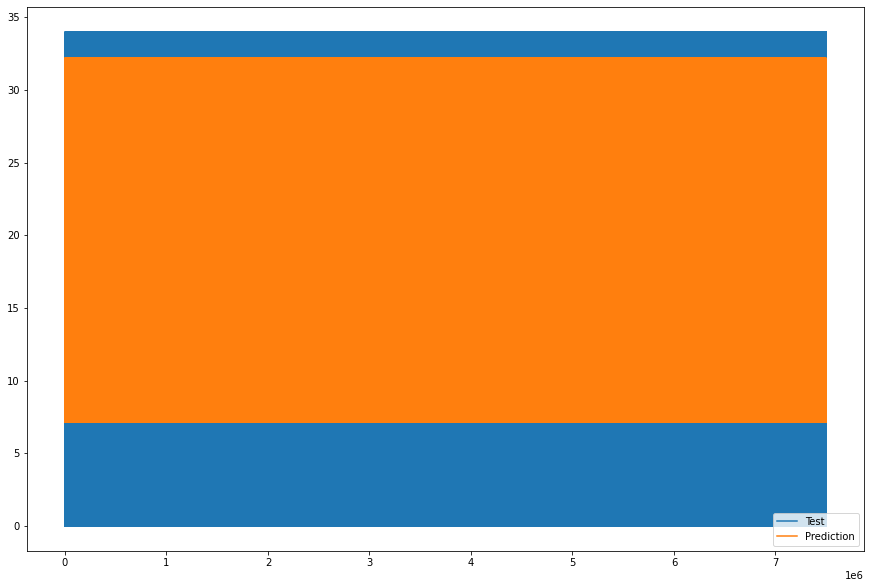

In [96]:
plt.figure(figsize=(15,10), facecolor='white')
plt.plot(Y_test, label = 'Test')
plt.plot(Predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()